## Exploratory Analysis for IDSRP Data

A Data-Driven Approach For Monitoring And Predictive Diagnosis Of Sucker Rod Pump System. https://shareok.org/handle/11244/334962

Tran, Ngoc Lam, Karami, Hamidreza, Bello, Opeyemi, and Catalin Teodoriu. "Tailoring Digital Approaches for Monitoring and Predictive Diagnosis for Sucker Rod Pumping Systems." Paper presented at the SPE Artificial Lift Conference and Exhibition - Americas, Galveston, Texas, USA, August 2022. doi: https://doi-org.ezproxy.lib.ou.edu/10.2118/209762-MS


## Import packages

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 
import pandas as pd

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

%pylab inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import datetime
import scipy as sp
import scipy.fftpack

from scipy import stats

import fnmatch
import functools
import itertools
import os
import pickle

Populating the interactive namespace from numpy and matplotlib


In [3]:
import os
os.getcwd()
#################################################################
# Default plotting parameters
FONTSIZE = 20
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = FONTSIZE

## Preprocessing data

In [4]:
# current directory csv files
csvs = [x for x in os.listdir('.') if x.endswith('.csv')]
# stats.csv -> stats
fns = [os.path.splitext(os.path.basename(x))[0] for x in csvs]

d = {}
for i in range(len(fns)):
    d[fns[i]] = pd.read_csv(csvs[i])

In [5]:
# This code reads output files and edits columns name
# Change csv files directory to the correct location

csvs = [x for x in os.listdir('csv-files-directory') if x.endswith('.csv')]  # change file directory
csvs
# Obtaine list of files name: file_name.csv -> file_name
fns = [os.path.splitext(os.path.basename(x))[0] for x in csvs]

d = {}
df={}
df_={}
for i in range(len(fns)):
    
    os.chdir('csv-files-directory') # change file directory
    
    d[fns[i]] = pd.read_csv(csvs[i])
    df[fns[i]]=d[fns[i]].dropna(how='all')
    df[fns[i]]=df[fns[i]].drop(df[fns[i]].index[[0]])
    df[fns[i]] = df[fns[i]].rename(columns={'Displacement(mm) (Collected)': 'Displacement.mm', 
                                            'Force(N) (Collected)': 'Force.N',
                                            'Pressure B1(psi) (Collected)': 'PressureB1.psi',
                                           'Pressure B2(psi) (Collected)':'PressureB2.psi',
                                           'Pressure T(psi) (Collected)': 'PressureT.psi',
                                           'Time ab. (sec) (Collected)':'Timeabs.sec'})
    df[fns[i]]['Displacement.mm']=pd.to_numeric(df[fns[i]]['Displacement.mm'])
    df[fns[i]]['Force.N']=pd.to_numeric(df[fns[i]]['Force.N'])
    df[fns[i]]['PressureB1.psi']=pd.to_numeric(df[fns[i]]['PressureB1.psi'])
    df[fns[i]]['PressureB2.psi']=pd.to_numeric(df[fns[i]]['PressureB2.psi'])
    df[fns[i]]['PressureT.psi']=pd.to_numeric(df[fns[i]]['PressureT.psi'])
    df[fns[i]]['Timeabs.sec']=pd.to_numeric(df[fns[i]]['Timeabs.sec'])
    df[fns[i]]=df[fns[i]][['Time.sec','Time.min','Displacement.mm','Force.N',
                           'PressureB1.psi','PressureB2.psi','PressureT.psi']]

In [6]:
#outlier handling by using z-score
z={}
for i in range(len(fns)):
    z[fns[i]]=np.abs(stats.zscore(df[fns[i]]))
    df[fns[i]] = df[fns[i]][(z[fns[i]] < 3).all(axis=1)].reset_index()

#  check index and corresponding file names
print(len(df))
file_names=list(df.keys())
for i in range (0, len(df)):
    print('index', i, 'file name:', file_names[i])

28
index 0 file name: 100_250_1000_SIN
index 1 file name: 100_250_1500_SIN
index 2 file name: 100_250_2000_SIN
index 3 file name: 100_250_500_SIN
index 4 file name: 100_300_1000_SIN
index 5 file name: 100_300_1500_SIN
index 6 file name: 100_350_1000_SIN
index 7 file name: 100_350_1500_SIN
index 8 file name: 100_350_2000_SIN
index 9 file name: 100_350_500_SIN
index 10 file name: 150_350_2000_SIN
index 11 file name: 200_350_2000_SIN
index 12 file name: 200_350_500_SIN
index 13 file name: 200_400_2000_SIN
index 14 file name: 200_400_500_SIN
index 15 file name: 50_200_1000_TPZ
index 16 file name: 50_200_1500_TPZ
index 17 file name: 50_200_2000_TPZ
index 18 file name: 50_200_500_TPZ
index 19 file name: 50_250_1000_TPZ
index 20 file name: 50_250_1500_TPZ
index 21 file name: 50_250_2000_TPZ
index 22 file name: 50_250_500_SIN
index 23 file name: 50_250_500_TPZ
index 24 file name: 50_300_1000_TPZ
index 25 file name: 50_300_1500_TPZ
index 26 file name: 50_300_2000_TPZ
index 27 file name: 50_300_

### Functions for data preparation

In [7]:
# define quotient, add more column fucntion 
def cycles(DF, spm): #this function returns cycle numbers based on SPM and time running 
    DF['cycles']=np.round(DF['Time.min']//spm,2)
    return DF[DF['cycles']>0].reset_index(drop=True)
#     return DF

def add_col(DF, SL, RPM, spm, shape):
    DF['PressureDiff']=DF['PressureB2.psi']-DF['PressureT.psi']
    DF['Time.min']=DF['Time.min']-DF['Time.min'][0]
    DF['StrokeLength']=SL
    DF['RPM']=RPM
    DF['SPM']=spm
    if shape =='TPZ':
        DF['shape']=0
    elif shape=='SIN':
        
        DF['shape']=1
    return DF

In [8]:
# pivot function for all variables
def pivot_creator(DF,mps):
    #create max and min pivot table
    pv_max=pd.pivot_table(DF, index='cycles',aggfunc={'PressureB1.psi':np.max,'PressureB2.psi':np.max,'PressureT.psi':np.max,'PressureDiff':np.max,'Force.N':np.max})
    pv_max=pv_max.rename(columns={"PressureB2.psi": "MaxPressureB2.psi", "PressureT.psi": "MaxPressureT.psi","Force.N": "MaxForce.N"})
    pv_min=pd.pivot_table(DF, index='cycles',aggfunc={'PressureB1.psi':np.min,'Force.N':np.min})
    pv_min=pv_min.rename(columns={"PressureB1.psi": "MinPressureB1.psi",'Force.N':'MinForce.N'})
    pv_tb=pv_max.join(pv_min,how='outer',on='cycles')
    #calculation other features
    pv_tb['cycles']=pv_tb.index
    pv_tb['time']=pv_tb.index*mps
    pv_tb['DeltaPressureB1']=pv_tb['PressureB1.psi']-pv_tb['MinPressureB1.psi']
    pv_tb['DeltaForce']=pv_tb['MaxForce.N']-pv_tb['MinForce.N']
    pv_tb['WaterPumpPerCycle']=(pv_tb['PressureB1.psi']-pv_tb['MinPressureB1.psi'])/.433
    pv_tb_reset_index=pv_tb.reset_index(drop=True)
    #merge table using left join
    DF=pd.merge(pv_tb_reset_index,DF[['Displacement.mm',  'PressureB1.psi',
       'cycles','StrokeLength', 'RPM', 'SPM', 'shape','filename']], on=['PressureB1.psi','cycles'], how='left')
    return DF


### All Files have SL=250, TPZ

In [9]:
a=[24, 25, 26, 27] #locate file index
dcopies=['','','','']
for i in range(0,len(a)):  #create a copy version
    dcopies[i]=df[fns[a[i]]].copy()
    
# calculate cycles and add more columns
mps_list=[0.129, 0.087, 0.07, 0.253] # min per stroke 
spm_list=[np.round(1/(i),1) for i in mps_list] #stroke per min
SL_list=[150,200,250]
RPM_list=[1000,1500,2000,500]
shape_list=['TPZ','SIN']
for i in range(0,len(a)):
    dcopies[i]=cycles(dcopies[i], mps_list[i])
    dcopies[i]=add_col(dcopies[i], SL_list[2], RPM_list[i], spm_list[i], shape_list[0])
    dcopies[i]['filename']=a[i]
    print(dcopies[i].shape)
    dcopies[i]=pivot_creator(dcopies[i],mps_list[i])
    print(dcopies[i].shape)

(11887, 15)
(159, 18)
(11890, 15)
(235, 18)
(12150, 15)
(296, 18)
(11982, 15)
(80, 18)


In [10]:
# concatenate whole files
data= []
for file in range(0,len(a)):
    data.append(dcopies[file])
whole_df = pd.concat(data, axis=0).reset_index(drop=True) #stacked up all files
whole_df=whole_df.sort_values(by=['RPM','SPM']).reset_index(drop=True) #sort value by RPM and SPM
print(whole_df.columns)

Index(['MaxForce.N', 'PressureB1.psi', 'MaxPressureB2.psi', 'PressureDiff',
       'MaxPressureT.psi', 'MinForce.N', 'MinPressureB1.psi', 'cycles', 'time',
       'DeltaPressureB1', 'DeltaForce', 'WaterPumpPerCycle', 'Displacement.mm',
       'StrokeLength', 'RPM', 'SPM', 'shape', 'filename'],
      dtype='object')


In [11]:
whole_df #print output

,MaxForce.N,PressureB1.psi,MaxPressureB2.psi,PressureDiff,MaxPressureT.psi,MinForce.N,MinPressureB1.psi,cycles,time,DeltaPressureB1,DeltaForce,WaterPumpPerCycle,Displacement.mm,StrokeLength,RPM,SPM,shape,filename
0,346.399812,0.609744,17.299074,17.315626,0.033277,126.031781,-0.853968,1.0,0.253,1.463712,220.368031,3.380397,254.908542,250,500,4.0,0,27
1,364.177865,-0.235748,17.069685,17.031371,0.227976,64.879794,-1.704824,2.0,0.506,1.469076,299.298071,3.392785,243.211652,250,500,4.0,0,27
2,370.304056,-0.500602,17.071056,16.909301,0.255543,68.885721,-1.905155,3.0,0.759,1.404553,301.418335,3.243771,254.107197,250,500,4.0,0,27
3,372.993117,-0.508916,16.812581,16.496897,0.395346,69.222868,-1.916361,4.0,1.012,1.407445,303.770249,3.250450,250.290140,250,500,4.0,0,27
4,384.744574,-0.507337,16.810852,16.490817,0.500816,59.164524,-1.956028,5.0,1.265,1.448691,325.580050,3.345707,256.494162,250,500,4.0,0,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
765,360.576957,-8.086663,17.373729,16.779334,0.714946,57.731834,-8.758318,292.0,20.440,0.671655,302.845123,1.551166,261.592251,250,2000,14.3,0,26
766,351.974174,-8.085382,17.610151,16.950280,0.733811,57.872742,-8.724761,293.0,20.510,0.639379,294.101432,1.476626,271.438519,250,2000,14.3,0,26
767,361.178215,-8.100969,17.549384,16.912967,0.838506,58.285139,-8.774233,294.0,20.580,0.673264,302.893076,1.554882,271.667521,250,2000,14.3,0,26
768,360.024390,-8.097780,17.537612,16.928315,0.668573,58.675403,-8.694839,295.0,20.650,0.597059,301.348987,1.378889,269.977617,250,2000,14.3,0,26


### Visualization

27   0.0039276330444487076
24   -0.029895439488872855
25   -0.06673321844007073
26   -0.04688745036496244


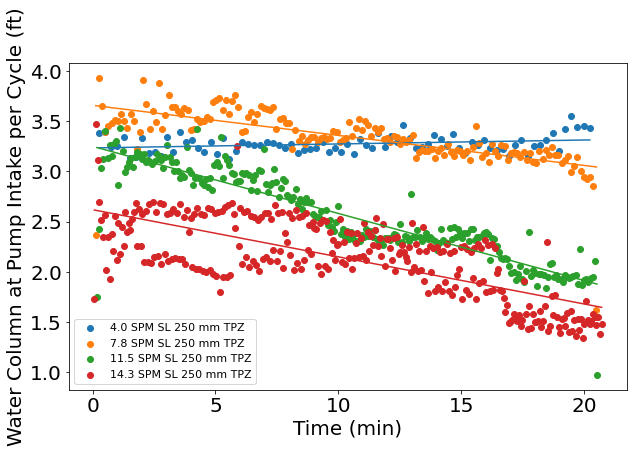

In [12]:
#rearrange index based on increasing SPM
b=[27, 24, 25, 26]
mps_list=[0.253, 0.129, 0.087, 0.07] # min per stroke
spm_list=[np.round(1/(i),1) for i in mps_list] #stroke per min 
shape_list=['TPZ','SIN']
SL_list=[150,200,250]

for i in range(0, len(b)):
    plt.scatter(whole_df[whole_df['filename']==b[i]]['time'],
                whole_df[whole_df['filename']==b[i]]['WaterPumpPerCycle'], 
                label=str(spm_list[i])+' SPM'+' SL '+str(SL_list[2]) +' mm' +' '+shape_list[0])
    plt.legend(loc=3, prop={'size': 11})
    plt.xlabel('Time (min)')
    plt.ylabel('Water Column at Pump Intake per Cycle (ft)')
###############################################################
#Regression slopes

    X=np.array(whole_df[whole_df['filename']==b[i]]['time'])
    y= np.array(whole_df[whole_df['filename']==b[i]]['WaterPumpPerCycle'])
    m, a = np.polyfit(X, y, 1)
    print(b[i],' ',m)
    plt.plot(X, m*X + a)

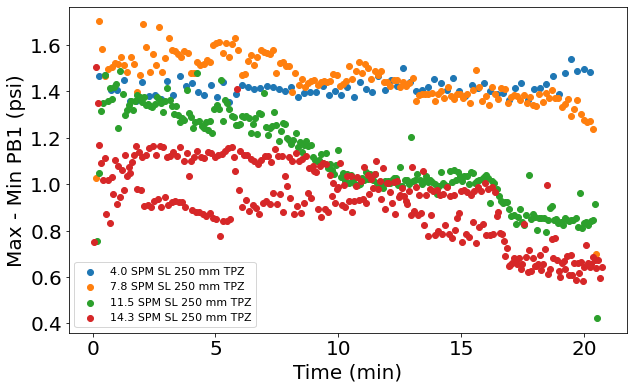

In [13]:
#rearrange index based on increasing SPM
b=[27, 24, 25, 26]
mps_list=[0.253, 0.129, 0.087, 0.07]
spm_list=[np.round(1/(i),1) for i in mps_list]

for i in range(0, len(b)):
    plt.scatter(whole_df[whole_df['filename']==b[i]]['time'],whole_df[whole_df['filename']==b[i]]['DeltaPressureB1'], 
                label=str(spm_list[i])+' SPM'+' SL '+str(SL_list[2]) +' mm'+' '+shape_list[0])
    plt.legend(loc=3, prop={'size': 11})
    plt.xlabel('Time (min)')
    plt.ylabel('Max - Min PB1 (psi)')


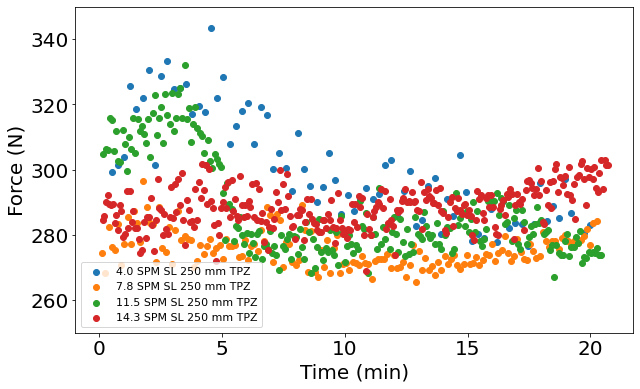

In [14]:
#rearrange index based on increasing SPM
b=[27, 24, 25, 26]
mps_list=[0.253, 0.129, 0.087, 0.07]
spm_list=[np.round(1/(i),1) for i in mps_list]

for i in range(0, len(b)):
    plt.scatter(whole_df[whole_df['filename']==b[i]]['time'],whole_df[whole_df['filename']==b[i]]['DeltaForce'], 
               label=str(spm_list[i])+' SPM'+' SL '+str(SL_list[2]) +' mm'+' '+shape_list[0])
    plt.legend(loc=3, prop={'size': 11})

    plt.xlabel('Time (min)')
    plt.ylabel('Force (N)')
    plt.ylim(250,350)